# Notebook 08: Pricing Break-Even Analysis

This notebook performs a comprehensive pricing sensitivity analysis to find break-even points between API and local pricing for each model combination.

## Features

- **Full Grid Search**: Complete coverage of pricing space (49,100 combinations)
- **Individual Data Points**: Uses actual experiment results, not aggregated means
- **Break-Even Detection**: Accurate identification of break-even points
- **Comprehensive Visualization**: Multiple plot types for different insights
- **Model-Specific Analysis**: Separate break-even analysis for each model combination

## Pricing Ranges

- **API Pricing**: $0.0001 to $0.01 per 1k tokens (increments of $0.0001) = 100 values
- **Local Hourly Pricing**: $0.1 to $5.0 per hour (increments of $0.01) = 491 values
- **Total Combinations**: 100 × 491 = 49,100 pricing combinations per model

## Usage

1. Load experiment data in Section 1
2. Define pricing grid in Section 2
3. Run break-even analysis in Section 4
4. View visualizations in Section 6
5. Export results in Section 8


## Section 1: Setup and Data Loading

Import libraries and load experiment data with individual data points.


In [7]:
# Import necessary modules
import sys
from pathlib import Path
import json
from datetime import datetime
from typing import Dict, List, Tuple, Optional

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# Interpolation for smooth curves
from scipy import interpolate

# Add the src directory to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

print("✅ All modules imported successfully!")


✅ All modules imported successfully!


In [8]:
# ============================================================================
# CONFIGURATION: Data Source Selection
# ============================================================================
# Specify which experiment run to analyze
# Options:
#   1. Specify exact timestamp (e.g., "20251123_164759")
#   2. Use "latest" to automatically find most recent
#   3. Specify full path to CSV file

EXPERIMENT_TIMESTAMP = "latest"  # Change to specific timestamp or path if needed
EXPERIMENT_CSV_PATH = None  # Optional: specify full path like "notebooks/results/experiments/nolh_20251123_164759/csv_exports_20251123_164759/01_full_experiment_summary_20251123_164759.csv"

# Results directory
RESULTS_DIR = project_root / "notebooks" / "results" / "pricing_break_even"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Create timestamped subdirectory for this analysis
analysis_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
ANALYSIS_DIR = RESULTS_DIR / f"analysis_{analysis_timestamp}"
ANALYSIS_DIR.mkdir(exist_ok=True)

print(f"✅ Configuration loaded")
print(f"   Analysis directory: {ANALYSIS_DIR}")
print(f"   Experiment timestamp: {EXPERIMENT_TIMESTAMP}")


✅ Configuration loaded
   Analysis directory: /home/goble54/spark-dev-workspace/GenerativeAI-Cost-Estimator/notebooks/results/pricing_break_even/analysis_20251123_170941
   Experiment timestamp: latest


In [9]:
# Load full experiment summary CSV
# This contains individual experiment data points (not aggregated)

if EXPERIMENT_CSV_PATH:
    # Use specified path
    summary_csv_path = Path(EXPERIMENT_CSV_PATH)
    if not summary_csv_path.exists():
        raise FileNotFoundError(f"CSV file not found: {summary_csv_path}")
    print(f"📄 Loading from specified path: {summary_csv_path}")
else:
    # Find experiment directory
    experiments_base = project_root / "notebooks" / "results" / "experiments"
    
    if EXPERIMENT_TIMESTAMP == "latest":
        # Try new structure first: nolh_YYYYMMDD_HHMMSS directories
        nolh_dirs = sorted(experiments_base.glob("nolh_*"), reverse=True)
        
        if nolh_dirs:
            # New timestamped structure
            experiment_dir = nolh_dirs[0]
            print(f"📁 Using latest experiment (new structure): {experiment_dir.name}")
            # Extract timestamp from directory name
            dir_timestamp = experiment_dir.name.split('_', 1)[1] if '_' in experiment_dir.name else None
            csv_exports_dir = experiment_dir / f"csv_exports_{dir_timestamp}" if dir_timestamp else experiment_dir / "csv_exports"
        else:
            # Fall back to old structure: nolh/ directory with timestamped csv_exports
            nolh_base_dir = experiments_base / "nolh"
            if not nolh_base_dir.exists():
                raise FileNotFoundError("No nolh experiment directories found!")
            
            # Find timestamped csv_exports directories
            csv_exports_dirs = sorted(nolh_base_dir.glob("csv_exports_*"), reverse=True)
            if csv_exports_dirs:
                csv_exports_dir = csv_exports_dirs[0]
                experiment_dir = nolh_base_dir
                print(f"📁 Using latest experiment (old structure): {csv_exports_dir.name}")
            else:
                # Try non-timestamped csv_exports
                csv_exports_dir = nolh_base_dir / "csv_exports"
                if not csv_exports_dir.exists():
                    raise FileNotFoundError("No csv_exports directories found in nolh/")
                experiment_dir = nolh_base_dir
                print(f"📁 Using experiment (old structure, no timestamp): csv_exports")
    else:
        # Use specified timestamp
        # Try new structure first
        experiment_dir = experiments_base / f"nolh_{EXPERIMENT_TIMESTAMP}"
        if experiment_dir.exists():
            print(f"📁 Using experiment (new structure): {experiment_dir.name}")
            csv_exports_dir = experiment_dir / f"csv_exports_{EXPERIMENT_TIMESTAMP}"
        else:
            # Try old structure
            nolh_base_dir = experiments_base / "nolh"
            csv_exports_dir = nolh_base_dir / f"csv_exports_{EXPERIMENT_TIMESTAMP}"
            if not csv_exports_dir.exists():
                raise FileNotFoundError(f"Experiment directory not found: {experiment_dir} or {csv_exports_dir}")
            experiment_dir = nolh_base_dir
            print(f"📁 Using experiment (old structure): {csv_exports_dir.name}")
    
    # Find the full experiment summary CSV
    summary_csv_files = list(csv_exports_dir.glob("01_full_experiment_summary_*.csv"))
    
    if not summary_csv_files:
        # Try without timestamp in filename (old format)
        summary_csv_files = list(csv_exports_dir.glob("01_full_experiment_summary.csv"))
    
    if not summary_csv_files:
        raise FileNotFoundError(f"No full experiment summary CSV found in {csv_exports_dir}")
    
    # Use most recent if multiple
    summary_csv_path = sorted(summary_csv_files, reverse=True)[0]
    print(f"📄 Loading: {summary_csv_path.name}")

# Load the CSV
experiment_df = pd.read_csv(summary_csv_path)
print(f"\n✅ Loaded experiment data:")
print(f"   Total experiments: {len(experiment_df)}")
print(f"   Columns: {len(experiment_df.columns)}")
print(f"\n📊 Data preview:")
print(experiment_df.head())


📁 Using latest experiment (old structure): csv_exports_20251123_164759
📄 Loading: 01_full_experiment_summary_20251123_164759.csv

✅ Loaded experiment data:
   Total experiments: 30
   Columns: 40

📊 Data preview:
             export_timestamp export_timestamp_readable  \
0  2025-11-23T16:47:59.732137       2025-11-23 16:47:59   
1  2025-11-23T16:47:59.732137       2025-11-23 16:47:59   
2  2025-11-23T16:47:59.732137       2025-11-23 16:47:59   
3  2025-11-23T16:47:59.732137       2025-11-23 16:47:59   
4  2025-11-23T16:47:59.732137       2025-11-23 16:47:59   

                                     experiment_name     gen_model  \
0  nolh_docs43_chunk326_q4_gengpt_oss_120b_embsno...  gpt-oss:120b   
1  nolh_docs17_chunk1783_q7_gengemma3_4b_embnomic...     gemma3:4b   
2  nolh_docs16_chunk2137_q4_genqwen3_latest_embem...  qwen3:latest   
3  nolh_docs45_chunk1560_q9_gengemma3_4b_embnomic...     gemma3:4b   
4  nolh_docs11_chunk2708_q5_gengemma3_12b_embqwen...    gemma3:12b   

           

In [10]:
# Verify required columns exist
required_columns = ['gen_model', 'embed_model', 'total_tokens', 'total_runtime_seconds']
missing_columns = [col for col in required_columns if col not in experiment_df.columns]

if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

# Display data statistics
print("📊 Experiment Data Statistics:")
print("=" * 80)
print(f"\nModel Combinations:")
model_combos = experiment_df.groupby(['gen_model', 'embed_model']).size()
print(model_combos)
print(f"\nTotal unique model combinations: {len(model_combos)}")

print(f"\nToken Statistics:")
print(f"   Min: {experiment_df['total_tokens'].min():,.0f}")
print(f"   Max: {experiment_df['total_tokens'].max():,.0f}")
print(f"   Mean: {experiment_df['total_tokens'].mean():,.0f}")
print(f"   Median: {experiment_df['total_tokens'].median():,.0f}")

print(f"\nRuntime Statistics (seconds):")
print(f"   Min: {experiment_df['total_runtime_seconds'].min():.2f}")
print(f"   Max: {experiment_df['total_runtime_seconds'].max():.2f}")
print(f"   Mean: {experiment_df['total_runtime_seconds'].mean():.2f}")
print(f"   Median: {experiment_df['total_runtime_seconds'].median():.2f}")

# Group by model for analysis
model_groups = experiment_df.groupby(['gen_model', 'embed_model'])
print(f"\n✅ Data ready for analysis!")
print(f"   {len(model_groups)} model combinations to analyze")


📊 Experiment Data Statistics:

Model Combinations:
gen_model     embed_model                    
gemma3:12b    embeddinggemma                     2
              qwen3-embedding:8b-fp16            2
gemma3:1b     nomic-embed-text:137m-v1.5-fp16    1
              snowflake-arctic-embed2:568m       1
gemma3:27b    embeddinggemma                     1
              nomic-embed-text:137m-v1.5-fp16    1
              qwen3-embedding:8b-fp16            1
              snowflake-arctic-embed2:568m       3
gemma3:4b     nomic-embed-text:137m-v1.5-fp16    3
              qwen3-embedding:8b-fp16            1
              snowflake-arctic-embed2:568m       2
gpt-oss:120b  qwen3-embedding:8b-fp16            1
              snowflake-arctic-embed2:568m       1
gpt-oss:20b   qwen3-embedding:8b-fp16            3
              snowflake-arctic-embed2:568m       1
qwen3:latest  embeddinggemma                     2
              qwen3-embedding:8b-fp16            2
              snowflake-arctic-embed

## Section 2: Pricing Grid Definition

Define the pricing ranges for API and local costs.


In [11]:
# ============================================================================
# PRICING GRID DEFINITION
# ============================================================================

# API Pricing: $0.0001 to $0.01 per 1k tokens
# Increments of $0.0001 = 100 values
api_price_min = 0.0001
api_price_max = 0.01
api_price_increment = 0.0001
api_prices = np.arange(api_price_min, api_price_max + api_price_increment, api_price_increment)

# Local Hourly Pricing: $0.1 to $5.0 per hour
# Increments of $0.01 = 491 values
hourly_price_min = 0.1
hourly_price_max = 5.0
hourly_price_increment = 0.01
hourly_prices = np.arange(hourly_price_min, hourly_price_max + hourly_price_increment, hourly_price_increment)

# Create full grid using meshgrid for efficient computation
API_GRID, HOURLY_GRID = np.meshgrid(api_prices, hourly_prices)

print("💰 Pricing Grid Definition:")
print("=" * 80)
print(f"\nAPI Pricing Range:")
print(f"   Min: ${api_price_min:.4f} per 1k tokens")
print(f"   Max: ${api_price_max:.4f} per 1k tokens")
print(f"   Increment: ${api_price_increment:.4f}")
print(f"   Number of values: {len(api_prices)}")

print(f"\nLocal Hourly Pricing Range:")
print(f"   Min: ${hourly_price_min:.2f} per hour")
print(f"   Max: ${hourly_price_max:.2f} per hour")
print(f"   Increment: ${hourly_price_increment:.2f}")
print(f"   Number of values: {len(hourly_prices)}")

print(f"\nTotal Pricing Combinations:")
total_combinations = len(api_prices) * len(hourly_prices)
print(f"   {len(api_prices)} × {len(hourly_prices)} = {total_combinations:,} combinations")

print(f"\n✅ Pricing grid created and ready for analysis!")


💰 Pricing Grid Definition:

API Pricing Range:
   Min: $0.0001 per 1k tokens
   Max: $0.0100 per 1k tokens
   Increment: $0.0001
   Number of values: 100

Local Hourly Pricing Range:
   Min: $0.10 per hour
   Max: $5.00 per hour
   Increment: $0.01
   Number of values: 491

Total Pricing Combinations:
   100 × 491 = 49,100 combinations

✅ Pricing grid created and ready for analysis!


## Section 3: Cost Calculation Functions

Vectorized functions for efficient cost calculations across the pricing grid.


In [12]:
# ============================================================================
# COST CALCULATION FUNCTIONS
# ============================================================================
# These functions are vectorized to efficiently compute costs across the entire pricing grid

def calculate_api_cost(tokens: float, api_price_per_1k: np.ndarray) -> np.ndarray:
    """
    Calculate API cost for given tokens and API price.
    
    Args:
        tokens: Number of tokens (scalar)
        api_price_per_1k: Array of API prices per 1k tokens
    
    Returns:
        Array of API costs for each price
    """
    # API cost = (tokens / 1000) * api_price_per_1k
    return (tokens / 1000.0) * api_price_per_1k


def calculate_local_cost(runtime_seconds: float, hourly_price: np.ndarray) -> np.ndarray:
    """
    Calculate local cost for given runtime and hourly price.
    
    Args:
        runtime_seconds: Runtime in seconds (scalar)
        hourly_price: Array of hourly prices
    
    Returns:
        Array of local costs for each hourly price
    """
    # Local cost = (runtime_seconds / 3600) * hourly_price
    runtime_hours = runtime_seconds / 3600.0
    return runtime_hours * hourly_price


def calculate_cost_difference(tokens: float, runtime_seconds: float,
                              api_price_per_1k: np.ndarray, hourly_price: np.ndarray) -> np.ndarray:
    """
    Calculate cost difference (API - Local) for given tokens, runtime, and pricing grid.
    
    This function uses broadcasting to efficiently compute costs for all pricing combinations.
    
    Args:
        tokens: Number of tokens (scalar)
        runtime_seconds: Runtime in seconds (scalar)
        api_price_per_1k: Array of API prices per 1k tokens (1D)
        hourly_price: Array of hourly prices (1D)
    
    Returns:
        2D array of cost differences (API - Local) for all pricing combinations
        Shape: (len(hourly_price), len(api_price_per_1k))
    """
    # Calculate API cost for all API prices
    # Shape: (len(api_price_per_1k),)
    api_costs = calculate_api_cost(tokens, api_price_per_1k)
    
    # Calculate local cost for all hourly prices
    # Shape: (len(hourly_price),)
    local_costs = calculate_local_cost(runtime_seconds, hourly_price)
    
    # Use broadcasting to create 2D grid
    # api_costs[:, np.newaxis] creates shape (len(api_price_per_1k), 1)
    # local_costs[np.newaxis, :] creates shape (1, len(hourly_price))
    # Result: (len(hourly_price), len(api_price_per_1k))
    api_cost_grid = api_costs[np.newaxis, :]  # Shape: (1, len(api_price_per_1k))
    local_cost_grid = local_costs[:, np.newaxis]  # Shape: (len(hourly_price), 1)
    
    # Broadcast and compute difference
    cost_difference = api_cost_grid - local_cost_grid
    
    return cost_difference


# Test the functions with a simple example
print("🧪 Testing cost calculation functions:")
test_tokens = 10000.0
test_runtime = 60.0  # 1 minute
test_api_price = np.array([0.001, 0.005, 0.01])
test_hourly_price = np.array([1.0, 2.0, 5.0])

test_api_cost = calculate_api_cost(test_tokens, test_api_price)
test_local_cost = calculate_local_cost(test_runtime, test_hourly_price)
test_diff = calculate_cost_difference(test_tokens, test_runtime, test_api_price, test_hourly_price)

print(f"\n   Test tokens: {test_tokens:,}")
print(f"   Test runtime: {test_runtime} seconds ({test_runtime/3600:.4f} hours)")
print(f"\n   API costs for prices {test_api_price}:")
print(f"      {test_api_cost}")
print(f"\n   Local costs for hourly rates {test_hourly_price}:")
print(f"      {test_local_cost}")
print(f"\n   Cost difference grid (API - Local):")
print(f"      Shape: {test_diff.shape}")
print(f"      Values:\n{test_diff}")
print(f"\n✅ Cost calculation functions working correctly!")


🧪 Testing cost calculation functions:

   Test tokens: 10,000.0
   Test runtime: 60.0 seconds (0.0167 hours)

   API costs for prices [0.001 0.005 0.01 ]:
      [0.01 0.05 0.1 ]

   Local costs for hourly rates [1. 2. 5.]:
      [0.01666667 0.03333333 0.08333333]

   Cost difference grid (API - Local):
      Shape: (3, 3)
      Values:
[[-0.00666667  0.03333333  0.08333333]
 [-0.02333333  0.01666667  0.06666667]
 [-0.07333333 -0.03333333  0.01666667]]

✅ Cost calculation functions working correctly!


## Section 4: Break-Even Analysis per Model

Calculate costs for all pricing combinations for each model using individual experiment data points.


In [13]:
# ============================================================================
# BREAK-EVEN ANALYSIS PER MODEL
# ============================================================================
# For each model combination, calculate costs across the entire pricing grid
# using individual experiment data points

# Storage for results
break_even_results = {}
model_analysis_results = {}

# Group experiments by model combination
model_groups = experiment_df.groupby(['gen_model', 'embed_model'])

print("🔬 Starting break-even analysis for each model combination...")
print("=" * 80)

for (gen_model, embed_model), group_df in model_groups:
    model_key = f"{gen_model} + {embed_model}"
    print(f"\n📊 Analyzing: {model_key}")
    print(f"   Experiments: {len(group_df)}")
    
    # Get individual data points
    tokens_list = group_df['total_tokens'].values
    runtime_list = group_df['total_runtime_seconds'].values
    
    print(f"   Tokens range: {tokens_list.min():,.0f} to {tokens_list.max():,.0f}")
    print(f"   Runtime range: {runtime_list.min():.2f}s to {runtime_list.max():.2f}s")
    
    # Calculate cost differences for each experiment across the pricing grid
    # We'll average across experiments to get representative break-even points
    all_cost_differences = []
    
    for i, (tokens, runtime) in enumerate(zip(tokens_list, runtime_list)):
        # Calculate cost difference grid for this experiment
        cost_diff = calculate_cost_difference(tokens, runtime, api_prices, hourly_prices)
        all_cost_differences.append(cost_diff)
        
        if (i + 1) % 5 == 0 or (i + 1) == len(tokens_list):
            print(f"      Processed {i + 1}/{len(tokens_list)} experiments...", end='\r')
    
    print()  # New line after progress
    
    # Average cost differences across all experiments for this model
    # This gives us the expected cost difference for this model at each pricing point
    avg_cost_difference = np.mean(all_cost_differences, axis=0)
    
    # Store results
    model_analysis_results[model_key] = {
        'gen_model': gen_model,
        'embed_model': embed_model,
        'num_experiments': len(group_df),
        'tokens_list': tokens_list,
        'runtime_list': runtime_list,
        'avg_cost_difference': avg_cost_difference,
        'all_cost_differences': all_cost_differences  # Store individual for variance analysis
    }
    
    print(f"   ✅ Analysis complete for {model_key}")

print(f"\n✅ Break-even analysis complete for {len(model_analysis_results)} model combinations!")


🔬 Starting break-even analysis for each model combination...

📊 Analyzing: gemma3:12b + embeddinggemma
   Experiments: 2
   Tokens range: 4,447 to 14,137
   Runtime range: 41.68s to 58.58s
      Processed 2/2 experiments...
   ✅ Analysis complete for gemma3:12b + embeddinggemma

📊 Analyzing: gemma3:12b + qwen3-embedding:8b-fp16
   Experiments: 2
   Tokens range: 5,358 to 7,322
   Runtime range: 52.20s to 90.34s
      Processed 2/2 experiments...
   ✅ Analysis complete for gemma3:12b + qwen3-embedding:8b-fp16

📊 Analyzing: gemma3:1b + nomic-embed-text:137m-v1.5-fp16
   Experiments: 1
   Tokens range: 22,821 to 22,821
   Runtime range: 25.64s to 25.64s
      Processed 1/1 experiments...
   ✅ Analysis complete for gemma3:1b + nomic-embed-text:137m-v1.5-fp16

📊 Analyzing: gemma3:1b + snowflake-arctic-embed2:568m
   Experiments: 1
   Tokens range: 12,119 to 12,119
   Runtime range: 17.48s to 17.48s
      Processed 1/1 experiments...
   ✅ Analysis complete for gemma3:1b + snowflake-arctic-em

## Section 5: Break-Even Point Detection

Identify where API cost equals Local cost (break-even points) for each model.


In [14]:
# ============================================================================
# BREAK-EVEN POINT DETECTION
# ============================================================================
# Find where cost_difference ≈ 0 (within tolerance)

BREAK_EVEN_TOLERANCE = 0.0001  # Tolerance for break-even detection ($0.0001)

print("🎯 Detecting break-even points...")
print("=" * 80)

for model_key, results in model_analysis_results.items():
    print(f"\n📊 Finding break-even points for: {model_key}")
    
    avg_cost_diff = results['avg_cost_difference']
    
    # Find where cost difference is approximately zero
    # abs(cost_difference) < tolerance
    break_even_mask = np.abs(avg_cost_diff) < BREAK_EVEN_TOLERANCE
    
    # Extract break-even points
    break_even_points = []
    
    # For each hourly price, find corresponding API prices where break-even occurs
    for hourly_idx, hourly_price in enumerate(hourly_prices):
        # Get cost differences for this hourly price across all API prices
        cost_diff_row = avg_cost_diff[hourly_idx, :]
        
        # Find API prices where break-even occurs
        break_even_indices = np.where(np.abs(cost_diff_row) < BREAK_EVEN_TOLERANCE)[0]
        
        for api_idx in break_even_indices:
            api_price = api_prices[api_idx]
            cost_diff = cost_diff_row[api_idx]
            
            break_even_points.append({
                'gen_model': results['gen_model'],
                'embed_model': results['embed_model'],
                'api_price_per_1k': api_price,
                'hourly_price': hourly_price,
                'cost_difference': cost_diff,
                'api_cost': calculate_api_cost(np.mean(results['tokens_list']), np.array([api_price]))[0],
                'local_cost': calculate_local_cost(np.mean(results['runtime_list']), np.array([hourly_price]))[0]
            })
    
    # Also find break-even curves by interpolating
    # For each hourly price, find the API price where cost difference = 0
    break_even_curves = []
    
    for hourly_idx, hourly_price in enumerate(hourly_prices):
        cost_diff_row = avg_cost_diff[hourly_idx, :]
        
        # Find where cost difference crosses zero
        # Look for sign changes
        sign_changes = np.where(np.diff(np.sign(cost_diff_row)))[0]
        
        for sign_change_idx in sign_changes:
            # Interpolate to find exact break-even point
            x0, x1 = api_prices[sign_change_idx], api_prices[sign_change_idx + 1]
            y0, y1 = cost_diff_row[sign_change_idx], cost_diff_row[sign_change_idx + 1]
            
            # Linear interpolation to find where y = 0
            if y0 != y1:  # Avoid division by zero
                api_price_break_even = x0 - y0 * (x1 - x0) / (y1 - y0)
                
                # Verify it's in valid range
                if api_price_min <= api_price_break_even <= api_price_max:
                    break_even_curves.append({
                        'gen_model': results['gen_model'],
                        'embed_model': results['embed_model'],
                        'api_price_per_1k': api_price_break_even,
                        'hourly_price': hourly_price,
                        'cost_difference': 0.0
                    })
    
    # Store break-even points
    break_even_results[model_key] = {
        'break_even_points': break_even_points,
        'break_even_curves': break_even_curves,
        'num_break_even_points': len(break_even_points),
        'num_break_even_curve_points': len(break_even_curves)
    }
    
    print(f"   Found {len(break_even_points)} break-even points")
    print(f"   Found {len(break_even_curves)} break-even curve points")

print(f"\n✅ Break-even detection complete!")


🎯 Detecting break-even points...

📊 Finding break-even points for: gemma3:12b + embeddinggemma
   Found 106 break-even points
   Found 491 break-even curve points

📊 Finding break-even points for: gemma3:12b + qwen3-embedding:8b-fp16
   Found 99 break-even points
   Found 311 break-even curve points

📊 Finding break-even points for: gemma3:1b + nomic-embed-text:137m-v1.5-fp16
   Found 41 break-even points
   Found 468 break-even curve points

📊 Finding break-even points for: gemma3:1b + snowflake-arctic-embed2:568m
   Found 80 break-even points
   Found 476 break-even curve points

📊 Finding break-even points for: gemma3:27b + embeddinggemma
   Found 103 break-even points
   Found 152 break-even curve points

📊 Finding break-even points for: gemma3:27b + nomic-embed-text:137m-v1.5-fp16
   Found 27 break-even points
   Found 372 break-even curve points

📊 Finding break-even points for: gemma3:27b + qwen3-embedding:8b-fp16
   Found 12 break-even points
   Found 133 break-even curve point

## Section 6: Visualization

Create comprehensive visualizations of break-even points and cost differences.


✅ Saved break-even curves: break_even_curves_20251123_170941.png


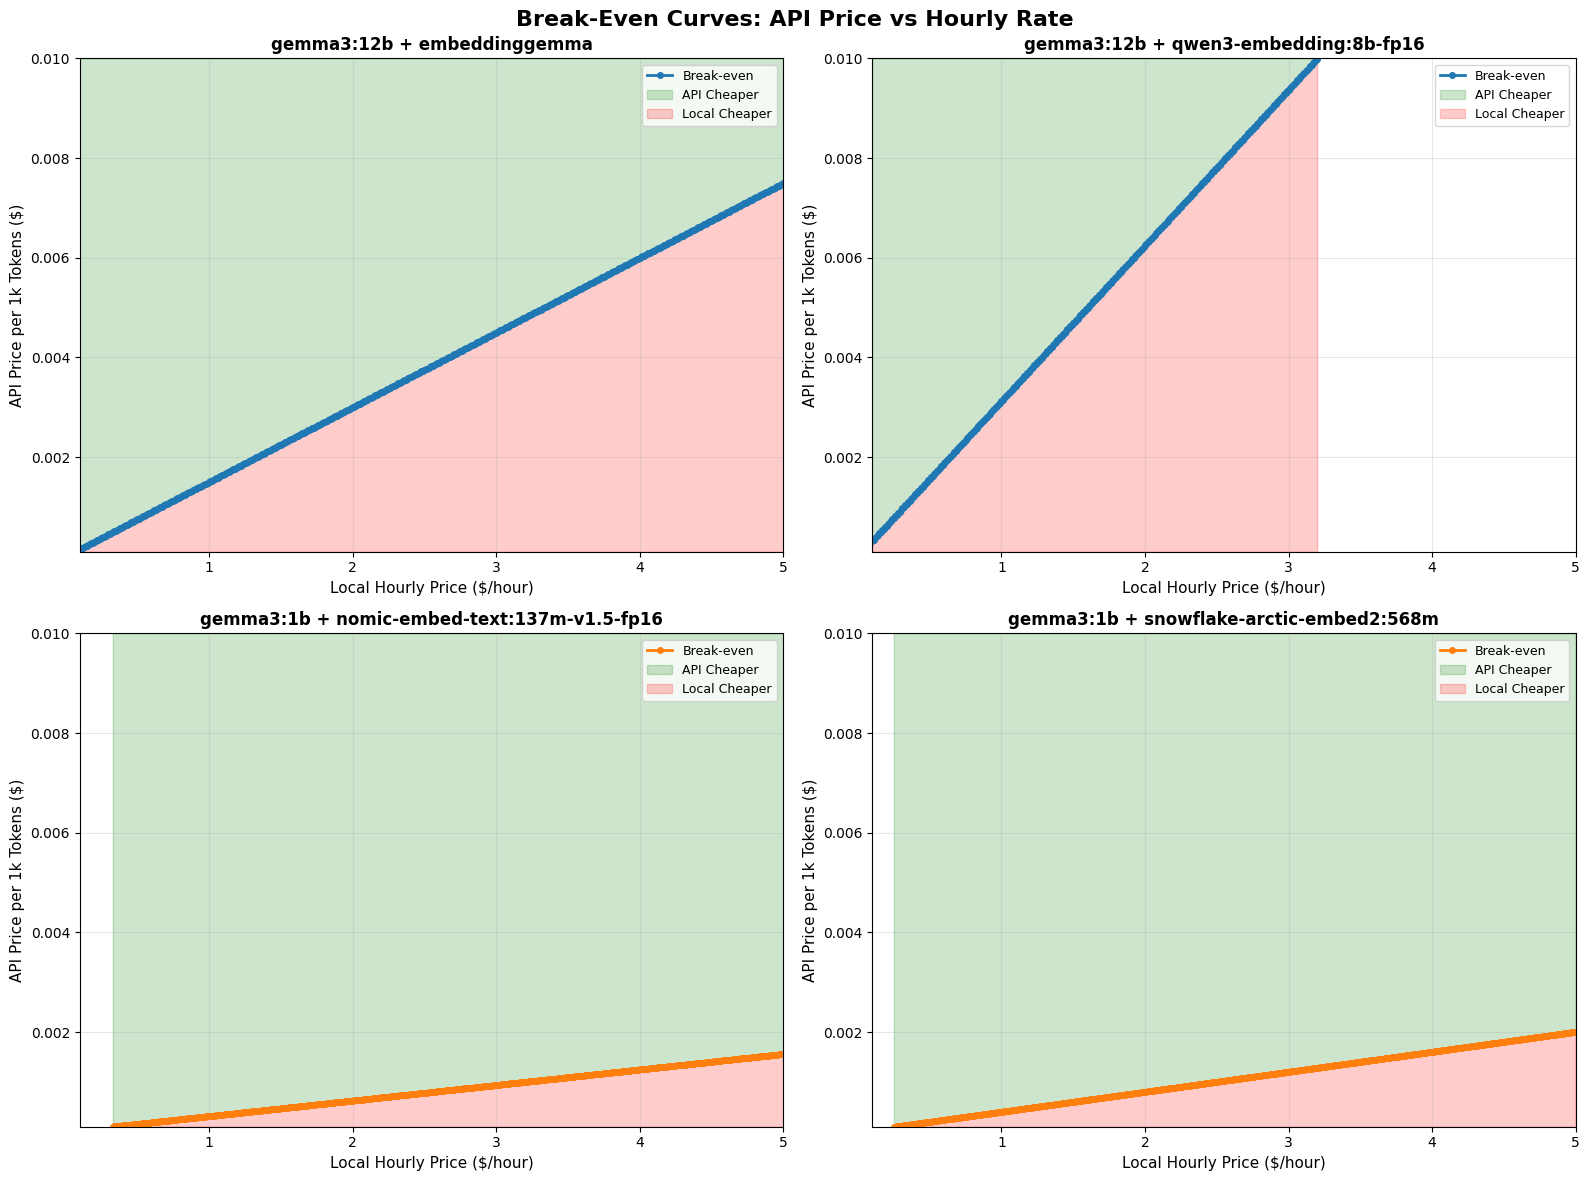

In [15]:
# ============================================================================
# VISUALIZATION: Break-Even Curves
# ============================================================================
# Plot break-even API price vs hourly rate for each model

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Break-Even Curves: API Price vs Hourly Rate', fontsize=16, fontweight='bold')
axes_flat = axes.flatten()

model_keys = list(model_analysis_results.keys())
colors = plt.cm.tab10(np.linspace(0, 1, len(model_keys)))

for idx, (model_key, results) in enumerate(model_analysis_results.items()):
    if idx >= len(axes_flat):
        break
    
    ax = axes_flat[idx]
    break_even_data = break_even_results[model_key]
    
    # Extract break-even curve points
    if break_even_data['break_even_curves']:
        curve_df = pd.DataFrame(break_even_data['break_even_curves'])
        
        # Sort by hourly price for smooth curve
        curve_df = curve_df.sort_values('hourly_price')
        
        # Plot break-even curve
        ax.plot(curve_df['hourly_price'], curve_df['api_price_per_1k'], 
               'o-', label='Break-even', linewidth=2, markersize=4, color=colors[idx])
        
        # Fill area: above curve = API cheaper, below = Local cheaper
        ax.fill_between(curve_df['hourly_price'], curve_df['api_price_per_1k'], 
                       api_price_max, alpha=0.2, color='green', label='API Cheaper')
        ax.fill_between(curve_df['hourly_price'], api_price_min, curve_df['api_price_per_1k'], 
                       alpha=0.2, color='red', label='Local Cheaper')
    
    ax.set_xlabel('Local Hourly Price ($/hour)', fontsize=11)
    ax.set_ylabel('API Price per 1k Tokens ($)', fontsize=11)
    ax.set_title(f'{model_key}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    ax.set_xlim(hourly_price_min, hourly_price_max)
    ax.set_ylim(api_price_min, api_price_max)

plt.tight_layout()
break_even_curves_path = ANALYSIS_DIR / f"break_even_curves_{analysis_timestamp}.png"
plt.savefig(break_even_curves_path, dpi=150, bbox_inches='tight')
print(f"✅ Saved break-even curves: {break_even_curves_path.name}")
plt.show()


✅ Saved heatmaps: cost_difference_heatmaps_20251123_170941.png


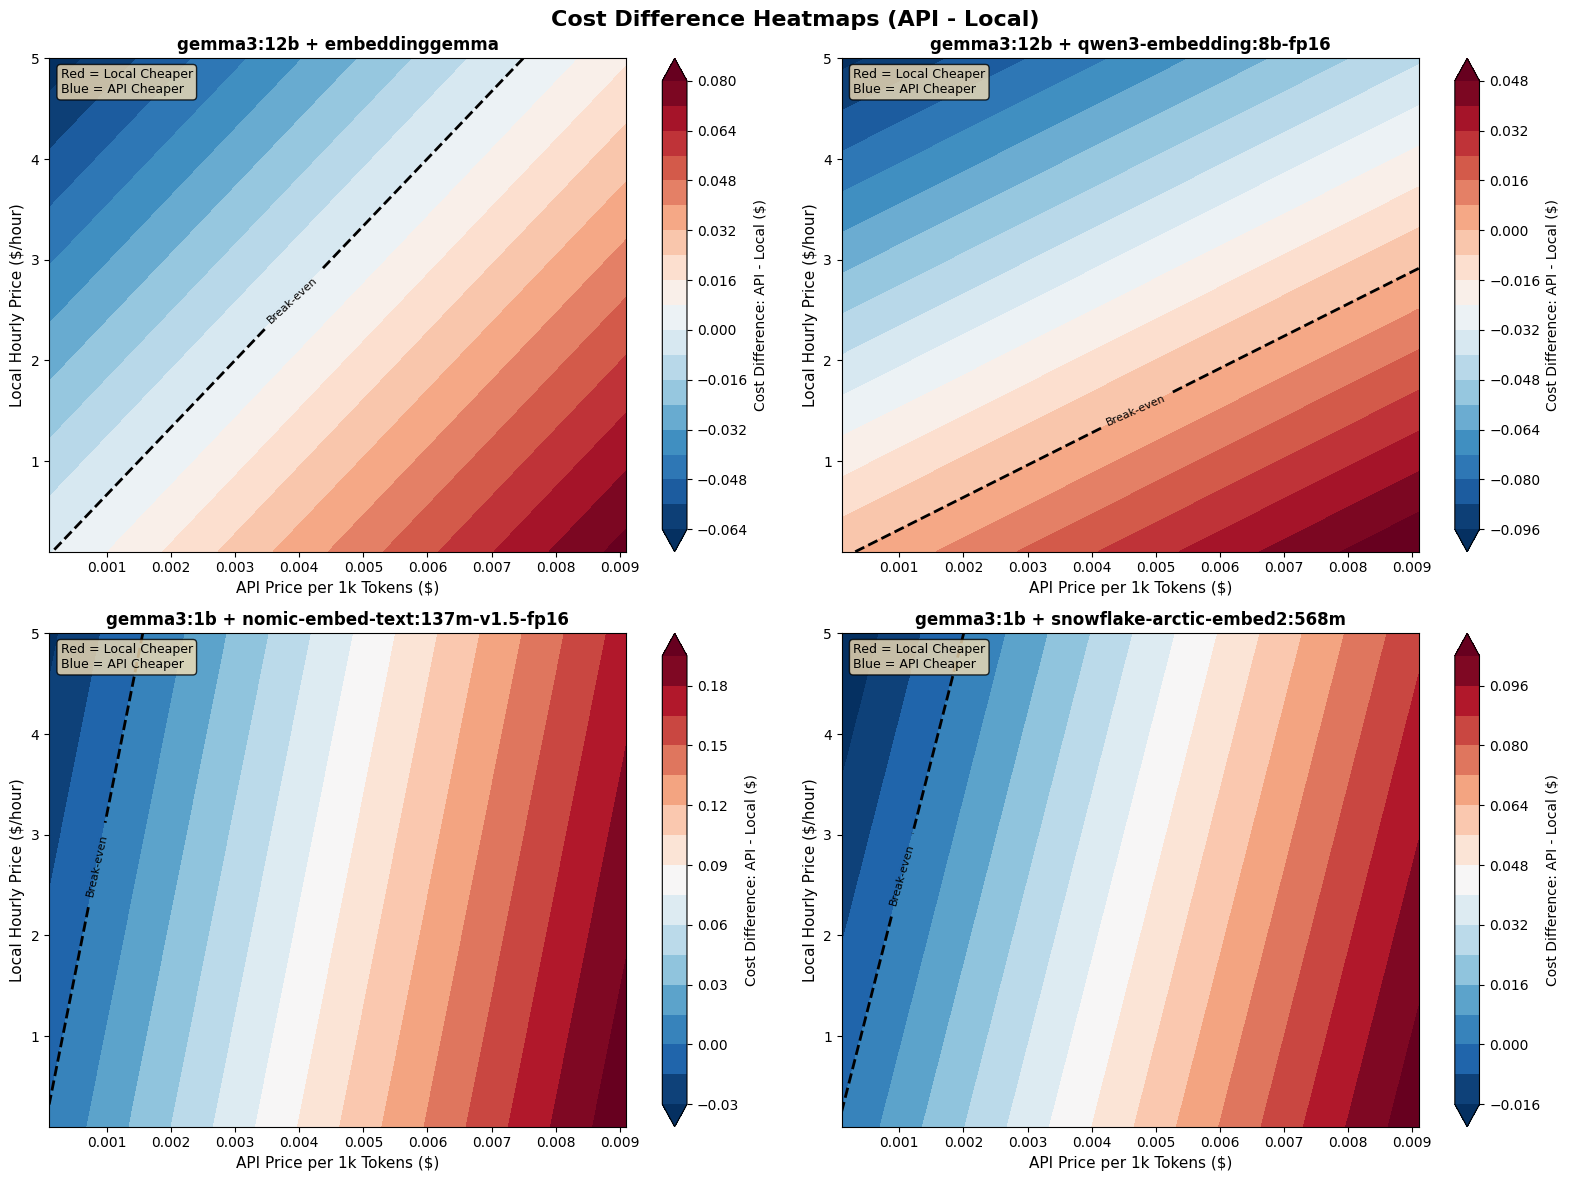

In [16]:
# ============================================================================
# VISUALIZATION: Cost Difference Heatmaps
# ============================================================================
# Show cost difference (API - Local) as heatmaps for each model

# Select a few representative models for heatmaps (to avoid too many plots)
selected_models = list(model_analysis_results.keys())[:4]  # First 4 models

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cost Difference Heatmaps (API - Local)', fontsize=16, fontweight='bold')
axes_flat = axes.flatten()

for idx, model_key in enumerate(selected_models):
    if idx >= len(axes_flat):
        break
    
    ax = axes_flat[idx]
    results = model_analysis_results[model_key]
    avg_cost_diff = results['avg_cost_difference']
    
    # Create heatmap
    # Note: We'll sample the grid for visualization (every 10th point) to make it manageable
    sample_rate = 10
    api_prices_sampled = api_prices[::sample_rate]
    hourly_prices_sampled = hourly_prices[::sample_rate]
    cost_diff_sampled = avg_cost_diff[::sample_rate, ::sample_rate]
    
    im = ax.contourf(api_prices_sampled, hourly_prices_sampled, cost_diff_sampled, 
                    levels=20, cmap='RdBu_r', extend='both')
    
    # Add break-even line (where cost difference = 0)
    contour = ax.contour(api_prices_sampled, hourly_prices_sampled, cost_diff_sampled, 
                        levels=[0], colors='black', linewidths=2, linestyles='--')
    ax.clabel(contour, inline=True, fontsize=8, fmt='Break-even')
    
    ax.set_xlabel('API Price per 1k Tokens ($)', fontsize=11)
    ax.set_ylabel('Local Hourly Price ($/hour)', fontsize=11)
    ax.set_title(f'{model_key}', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Cost Difference: API - Local ($)', fontsize=10)
    
    # Add text annotation
    ax.text(0.02, 0.98, f'Red = Local Cheaper\nBlue = API Cheaper', 
           transform=ax.transAxes, fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
heatmaps_path = ANALYSIS_DIR / f"cost_difference_heatmaps_{analysis_timestamp}.png"
plt.savefig(heatmaps_path, dpi=150, bbox_inches='tight')
print(f"✅ Saved heatmaps: {heatmaps_path.name}")
plt.show()


✅ Saved model comparison: break_even_comparison_20251123_170941.png


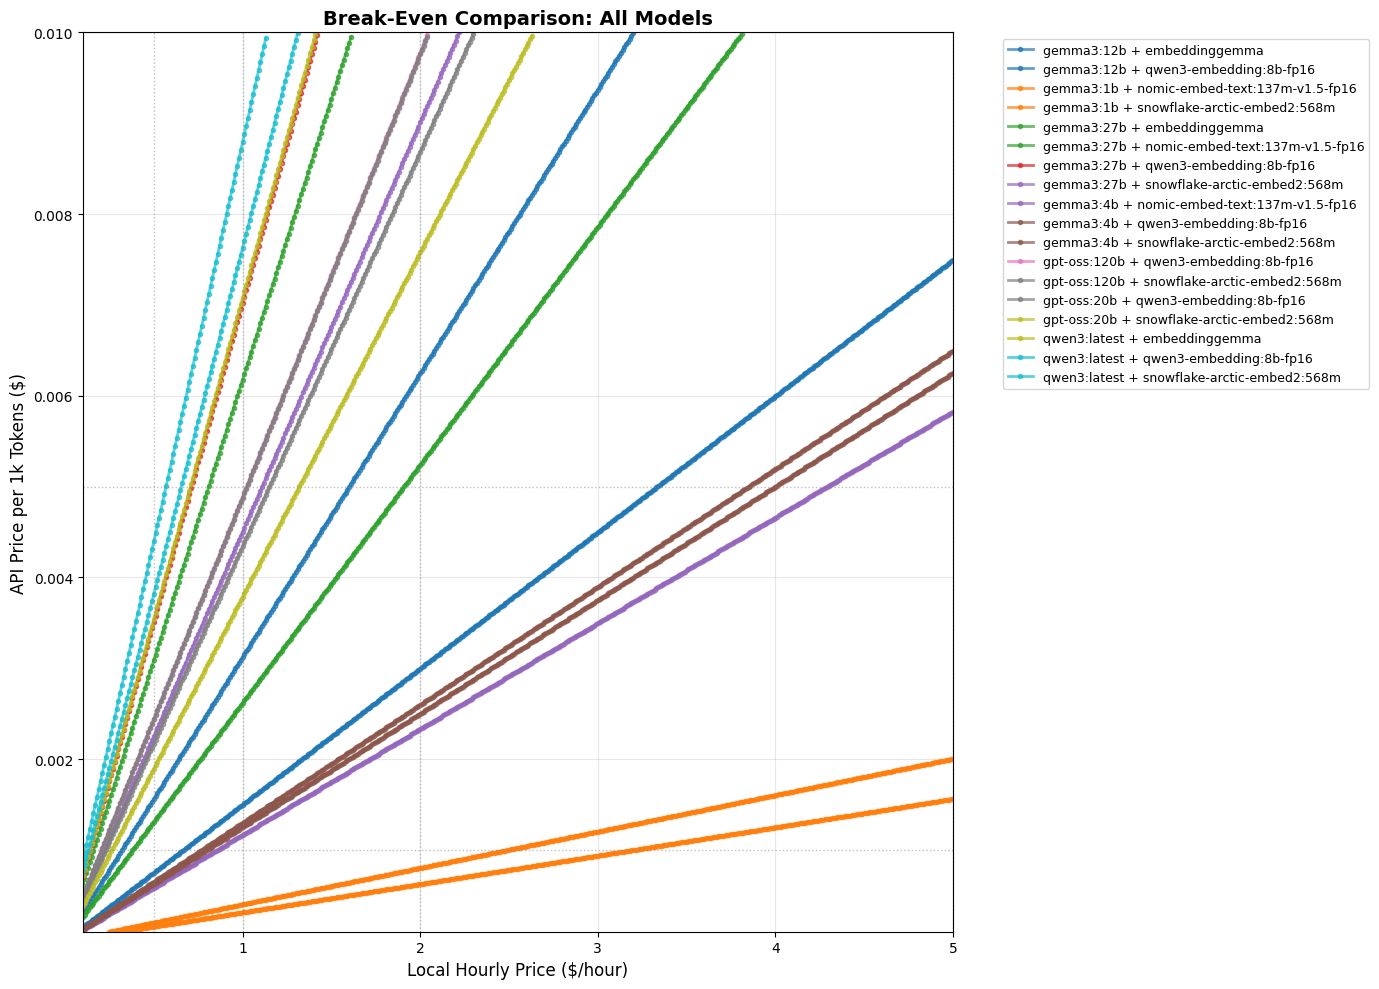

In [17]:
# ============================================================================
# VISUALIZATION: Model Comparison - Break-Even Points
# ============================================================================
# Compare break-even points across all models on a single plot

fig, ax = plt.subplots(figsize=(14, 10))

colors = plt.cm.tab10(np.linspace(0, 1, len(model_analysis_results)))

for idx, (model_key, results) in enumerate(model_analysis_results.items()):
    break_even_data = break_even_results[model_key]
    
    if break_even_data['break_even_curves']:
        curve_df = pd.DataFrame(break_even_data['break_even_curves'])
        curve_df = curve_df.sort_values('hourly_price')
        
        # Plot break-even curve for this model
        ax.plot(curve_df['hourly_price'], curve_df['api_price_per_1k'], 
               'o-', label=model_key, linewidth=2, markersize=3, color=colors[idx], alpha=0.7)

ax.set_xlabel('Local Hourly Price ($/hour)', fontsize=12)
ax.set_ylabel('API Price per 1k Tokens ($)', fontsize=12)
ax.set_title('Break-Even Comparison: All Models', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.set_xlim(hourly_price_min, hourly_price_max)
ax.set_ylim(api_price_min, api_price_max)

# Add reference lines for common pricing points
common_hourly = [0.5, 1.0, 2.0, 5.0]
for h in common_hourly:
    ax.axvline(x=h, color='gray', linestyle=':', alpha=0.5, linewidth=1)

common_api = [0.001, 0.005, 0.01]
for a in common_api:
    ax.axhline(y=a, color='gray', linestyle=':', alpha=0.5, linewidth=1)

plt.tight_layout()
comparison_path = ANALYSIS_DIR / f"break_even_comparison_{analysis_timestamp}.png"
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
print(f"✅ Saved model comparison: {comparison_path.name}")
plt.show()


## Section 7: Break-Even Summary Tables

Create summary tables showing break-even points for common pricing values.


In [18]:
# ============================================================================
# BREAK-EVEN SUMMARY TABLES
# ============================================================================

# Table 1: Break-even API price for common hourly rates
common_hourly_rates = [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]

summary_data = []
for model_key, results in model_analysis_results.items():
    break_even_data = break_even_results[model_key]
    
    if break_even_data['break_even_curves']:
        curve_df = pd.DataFrame(break_even_data['break_even_curves'])
        
        row = {
            'gen_model': results['gen_model'],
            'embed_model': results['embed_model'],
            'model_combination': model_key
        }
        
        # For each common hourly rate, find closest break-even API price
        for hourly_rate in common_hourly_rates:
            # Find closest hourly price in break-even curve
            closest_idx = np.argmin(np.abs(curve_df['hourly_price'] - hourly_rate))
            closest_hourly = curve_df.iloc[closest_idx]['hourly_price']
            
            # If close enough, use that API price; otherwise interpolate
            if abs(closest_hourly - hourly_rate) < 0.1:
                api_price = curve_df.iloc[closest_idx]['api_price_per_1k']
            else:
                # Interpolate
                if len(curve_df) > 1:
                    interp_func = interpolate.interp1d(curve_df['hourly_price'], 
                                                      curve_df['api_price_per_1k'],
                                                      kind='linear', 
                                                      bounds_error=False, 
                                                      fill_value=np.nan)
                    api_price = interp_func(hourly_rate)
                else:
                    api_price = np.nan
            
            row[f'api_price_at_${hourly_rate}_per_hour'] = api_price if not np.isnan(api_price) else None
        
        summary_data.append(row)

break_even_summary_df = pd.DataFrame(summary_data)

print("📊 Break-Even Summary: API Price at Common Hourly Rates")
print("=" * 100)
print(break_even_summary_df.to_string(index=False))
print()


📊 Break-Even Summary: API Price at Common Hourly Rates
   gen_model                     embed_model                            model_combination  api_price_at_$0.5_per_hour  api_price_at_$1.0_per_hour  api_price_at_$1.5_per_hour  api_price_at_$2.0_per_hour  api_price_at_$3.0_per_hour  api_price_at_$4.0_per_hour  api_price_at_$5.0_per_hour
  gemma3:12b                  embeddinggemma                  gemma3:12b + embeddinggemma                    0.000749                    0.001499                    0.002248                    0.002997                    0.004496                    0.005994                    0.007493
  gemma3:12b         qwen3-embedding:8b-fp16         gemma3:12b + qwen3-embedding:8b-fp16                    0.001561                    0.003123                    0.004684                    0.006245                    0.009368                         NaN                         NaN
   gemma3:1b nomic-embed-text:137m-v1.5-fp16  gemma3:1b + nomic-embed-text:137m-v1.5-fp

In [19]:
# Table 2: Break-even hourly rate for common API prices
common_api_prices = [0.0005, 0.001, 0.002, 0.005, 0.01]

summary_data2 = []
for model_key, results in model_analysis_results.items():
    break_even_data = break_even_results[model_key]
    
    if break_even_data['break_even_curves']:
        curve_df = pd.DataFrame(break_even_data['break_even_curves'])
        curve_df = curve_df.sort_values('api_price_per_1k')
        
        row = {
            'gen_model': results['gen_model'],
            'embed_model': results['embed_model'],
            'model_combination': model_key
        }
        
        # For each common API price, find closest break-even hourly rate
        for api_price in common_api_prices:
            # Find closest API price in break-even curve
            closest_idx = np.argmin(np.abs(curve_df['api_price_per_1k'] - api_price))
            closest_api = curve_df.iloc[closest_idx]['api_price_per_1k']
            
            # If close enough, use that hourly rate; otherwise interpolate
            if abs(closest_api - api_price) < 0.0005:
                hourly_rate = curve_df.iloc[closest_idx]['hourly_price']
            else:
                # Interpolate
                if len(curve_df) > 1:
                    interp_func = interpolate.interp1d(curve_df['api_price_per_1k'], 
                                                      curve_df['hourly_price'],
                                                      kind='linear', 
                                                      bounds_error=False, 
                                                      fill_value=np.nan)
                    hourly_rate = interp_func(api_price)
                else:
                    hourly_rate = np.nan
            
            row[f'hourly_rate_at_${api_price}_per_1k_tokens'] = hourly_rate if not np.isnan(hourly_rate) else None
        
        summary_data2.append(row)

break_even_summary2_df = pd.DataFrame(summary_data2)

print("📊 Break-Even Summary: Hourly Rate at Common API Prices")
print("=" * 100)
print(break_even_summary2_df.to_string(index=False))
print()


📊 Break-Even Summary: Hourly Rate at Common API Prices
   gen_model                     embed_model                            model_combination  hourly_rate_at_$0.0005_per_1k_tokens  hourly_rate_at_$0.001_per_1k_tokens  hourly_rate_at_$0.002_per_1k_tokens  hourly_rate_at_$0.005_per_1k_tokens  hourly_rate_at_$0.01_per_1k_tokens
  gemma3:12b                  embeddinggemma                  gemma3:12b + embeddinggemma                                  0.33                                 0.67                                 1.33                                 3.34                                 NaN
  gemma3:12b         qwen3-embedding:8b-fp16         gemma3:12b + qwen3-embedding:8b-fp16                                  0.16                                 0.32                                 0.64                                 1.60                                3.20
   gemma3:1b nomic-embed-text:137m-v1.5-fp16  gemma3:1b + nomic-embed-text:137m-v1.5-fp16                               

## Section 8: Data Export

Export all break-even analysis results to CSV files with timestamps.


In [20]:
# ============================================================================
# DATA EXPORT
# ============================================================================

export_timestamp = datetime.now().isoformat()
export_timestamp_readable = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
export_timestamp_filename = datetime.now().strftime("%Y%m%d_%H%M%S")

print("💾 Exporting break-even analysis results...")
print("=" * 80)

# 1. Export all break-even points
all_break_even_points = []
for model_key, break_even_data in break_even_results.items():
    if break_even_data['break_even_points']:
        for point in break_even_data['break_even_points']:
            point['export_timestamp'] = export_timestamp
            point['export_timestamp_readable'] = export_timestamp_readable
            all_break_even_points.append(point)

if all_break_even_points:
    break_even_points_df = pd.DataFrame(all_break_even_points)
    break_even_points_path = ANALYSIS_DIR / f"break_even_points_{export_timestamp_filename}.csv"
    break_even_points_df.to_csv(break_even_points_path, index=False)
    print(f"✅ 1. Break-Even Points")
    print(f"   File: {break_even_points_path.name}")
    print(f"   Rows: {len(break_even_points_df)}")
    print()

# 2. Export break-even curves
all_break_even_curves = []
for model_key, break_even_data in break_even_results.items():
    if break_even_data['break_even_curves']:
        for point in break_even_data['break_even_curves']:
            point['export_timestamp'] = export_timestamp
            point['export_timestamp_readable'] = export_timestamp_readable
            all_break_even_curves.append(point)

if all_break_even_curves:
    break_even_curves_df = pd.DataFrame(all_break_even_curves)
    break_even_curves_path = ANALYSIS_DIR / f"break_even_curves_{export_timestamp_filename}.csv"
    break_even_curves_df.to_csv(break_even_curves_path, index=False)
    print(f"✅ 2. Break-Even Curves")
    print(f"   File: {break_even_curves_path.name}")
    print(f"   Rows: {len(break_even_curves_df)}")
    print()

# 3. Export summary tables
if not break_even_summary_df.empty:
    break_even_summary_df['export_timestamp'] = export_timestamp
    break_even_summary_df['export_timestamp_readable'] = export_timestamp_readable
    cols = ['export_timestamp', 'export_timestamp_readable'] + [c for c in break_even_summary_df.columns if c not in ['export_timestamp', 'export_timestamp_readable']]
    break_even_summary_df = break_even_summary_df[cols]
    
    summary_path = ANALYSIS_DIR / f"break_even_summary_api_prices_{export_timestamp_filename}.csv"
    break_even_summary_df.to_csv(summary_path, index=False)
    print(f"✅ 3. Break-Even Summary (API Prices)")
    print(f"   File: {summary_path.name}")
    print(f"   Rows: {len(break_even_summary_df)}")
    print()

if not break_even_summary2_df.empty:
    break_even_summary2_df['export_timestamp'] = export_timestamp
    break_even_summary2_df['export_timestamp_readable'] = export_timestamp_readable
    cols = ['export_timestamp', 'export_timestamp_readable'] + [c for c in break_even_summary2_df.columns if c not in ['export_timestamp', 'export_timestamp_readable']]
    break_even_summary2_df = break_even_summary2_df[cols]
    
    summary2_path = ANALYSIS_DIR / f"break_even_summary_hourly_rates_{export_timestamp_filename}.csv"
    break_even_summary2_df.to_csv(summary2_path, index=False)
    print(f"✅ 4. Break-Even Summary (Hourly Rates)")
    print(f"   File: {summary2_path.name}")
    print(f"   Rows: {len(break_even_summary2_df)}")
    print()

print(f"📁 All files saved to: {ANALYSIS_DIR}")
print(f"✅ Export complete!")


💾 Exporting break-even analysis results...
✅ 1. Break-Even Points
   File: break_even_points_20251123_170942.csv
   Rows: 887

✅ 2. Break-Even Curves
   File: break_even_curves_20251123_170942.csv
   Rows: 5312

✅ 3. Break-Even Summary (API Prices)
   File: break_even_summary_api_prices_20251123_170942.csv
   Rows: 18

✅ 4. Break-Even Summary (Hourly Rates)
   File: break_even_summary_hourly_rates_20251123_170942.csv
   Rows: 18

📁 All files saved to: /home/goble54/spark-dev-workspace/GenerativeAI-Cost-Estimator/notebooks/results/pricing_break_even/analysis_20251123_170941
✅ Export complete!
